# Difftest Results

Connect to results database:

In [24]:
import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen", "CLgen w. cl_launcher", "CLgen w. co"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult, cl_launcherCLgenResult, coCLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES]),
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen,CLgen w. cl_launcher,CLgen w. co
#. Programs,10001,10001,9238,7879,2385,3385
#. Testbeds,8,5,5,8,7,7
#. Params,4,4,4,4,4,4
#. Results,249455,200020,193477,140297,66780,53840


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

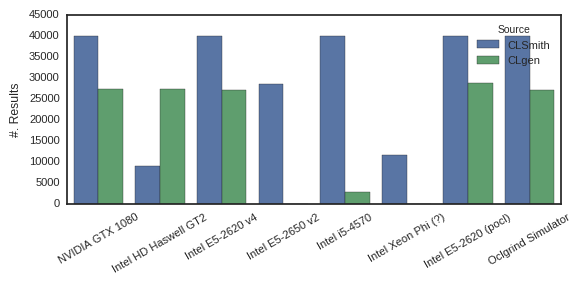

In [3]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

def get_testbed_info(config_id, testbed_id, source, results_table):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    num_results = session.query(results_table).filter(results_table.testbed_id == testbed_id).count()
    return {
        "Device": device_str(testbed.device),
        "#. Results": num_results,
        "Source": source,
    }

data = []
for source, table in [("CLSmith", CLSmithResult), ("CLgen", CLgenResult)]:
    data += [get_testbed_info(*x, source, table) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="#. Results", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("#. Results")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
viz.finalise(figsize=(6, 3))

In [ ]:
def get_testbed_info(config_id, testbed_id, source, results_table, program_table, reduction_table, harness_table=None):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    total_time = session.query(sql.sql.func.sum(results_table.runtime))\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
    total_time += session.query(sql.sql.func.sum(reduction_table.runtime))\
        .join(results_table)\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
#     if harness_table:
#         total_time += session.query(sql.sql.func.sum(harness_table.generation_time)).filter(Testbed.id == testbed_id).first()[0] or 0
    return {
        "Device": device_str(testbed.device),
        "Test Time": total_time / 3600,
        "Source": source,
    }

data = []
for row in [("CLSmith", CLSmithResult, CLSmithProgram, CLSmithReduction), 
                       ("CLgen", CLgenResult, CLgenProgram, CLgenReduction, CLgenHarness)]:
    data += [get_testbed_info(*x, *row) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="Test Time", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("Time (hours)")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
ax.set_yscale("log", nonposy='clip')
viz.finalise(figsize=(6, 3))

In [ ]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict

def get_total_submitted(testbed: Testbed):
    submitable_results = [coCLgenResult, cl_launcherCLgenResult]
    
    def get_submitted(table):
        return session.query(table).filter(table.testbed_id == testbed.id, table.submitted).count()

    def get_generated(table):
        return session.query(table).filter(table.testbed_id == testbed.id, sql.or_(table.submitted, table.dupe)).count()
    
    return (
        sum(get_generated(table) for table in submitable_results), 
        sum(get_submitted(table) for table in submitable_results)
    )


def get_row(config_id, testbed_id):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Device"] = testbed.device
    d["Platform"] = platform_str(testbed.platform)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    d["B.R. Generated"], d["B.R. Submitted"] = get_total_submitted(testbed)
    return d

table = pd.DataFrame([get_row(*x) for x in CONFIGURATIONS])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile, index=None)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

In [25]:
%run mkmegatable.ipy

insufficient CLgenResults for GeForce GTX 1080 True
insufficient CLgenResults for GeForce GTX 1080 False
insufficient CLgenResults for Intel(R) HD Graphics Haswell GT2 Desktop True
insufficient CLSmithResults for Intel(R) HD Graphics Haswell GT2 Desktop False
insufficient CLgenResults for Intel(R) HD Graphics Haswell GT2 Desktop False
insufficient CLgenResults for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz True
insufficient CLgenResults for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz False
insufficient CLSmithResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz True
insufficient CLgenResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz True
insufficient CLSmithResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz False
insufficient CLgenResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz False
insufficient CLSmithResults for Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz True
insufficient CLgenResults for Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz True
insufficient CLgen

Current branch master is up to date.
[master 531b4ba] auto: build/tab/megatable.tex
 1 file changed, 1 insertion(+), 1 deletion(-)
fatal: unable to access 'https://git.overleaf.com/8608915dsywxshwwjmw/': The requested URL returned error: 503


## Runtimes

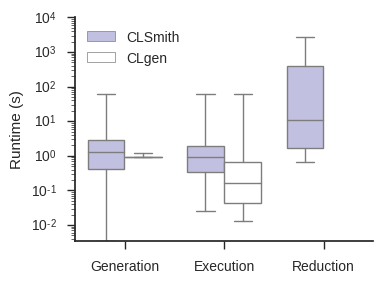

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/runtimes.pdf
[master c3d4d23] auto: build/img/runtimes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
fatal: unable to access 'https://git.overleaf.com/8608915dsywxshwwjmw/': The requested URL returned error: 503


In [32]:
sns.set(style="ticks")

def plot_runtimes(*args, **kwargs):
    TIMEOUT = 60
    
    # CLSmith times
    q = session.query(
            CLSmithResult.runtime, 
            CLSmithProgram.runtime, 
            sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None)
    clsmith_times = np.array([row for row in q])
    
    # CLgen times
    q = session.query(
            CLgenResult.runtime,
            sql.sql.func.ifnull(CLgenProgram.runtime, clgen_generation_time) + CLgenHarness.generation_time,
            sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenHarness)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None)
    clgen_times = np.array([row for row in q])

    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])

    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
       # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Kernel sizes

In [29]:
sns.set(style="ticks")
from collections import defaultdict

def get_kernel_sizes():
    TIMEOUT = 60
    
    # CLSmith times
    clsmith = session.query(
            CLSmithResult.classification,
            sql.sql.func.ifnull(CLSmithReduction.src, CLSmithProgram.src))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None,
                CLSmithResult.classification != "pass")
    
    clgen = session.query(
            CLgenResult.classification,
            sql.sql.func.ifnull(CLgenReduction.src, CLgenProgram.src))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None,
                CLgenResult.classification != "pass")
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

table = get_kernel_sizes()

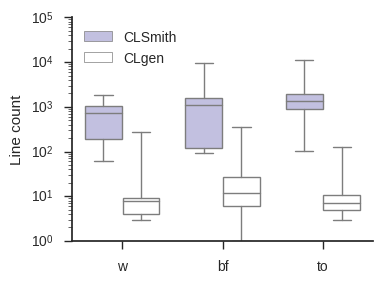

remote: Counting objects: 11, done
remote: Finding sources: 100% (6/6)
remote: Total 6 (delta 5), reused 6 (delta 5)
Unpacking objects: 100% (6/6), done.
From https://git.overleaf.com/8608915dsywxshwwjmw
   824b130..ad6c6a5  master     -> origin/master
First, rewinding head to replay your work on top of it...
Fast-forwarded master to ad6c6a53ff701da9d51d2f95c7d7fb0729d17198.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/kernel-sizes.pdf
[master ac54e48] auto: build/img/kernel-sizes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.43 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   ad6c6a5..ac54e48  master -> master


In [31]:
def plot_kernel_sizes(table, *args, **kwargs):
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
from matplotlib.ticker import FuncFormatter

def plot_totaltime(ax, results_table, programs_table, reductions_table):
    generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
    runtime = results_table.runtime
    reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
    total_time = generation_time + runtime + reduction_time

    q = session.query(total_time)\
        .outerjoin(programs_table)\
        .outerjoin(reductions_table)\
        .filter(results_table.classification != None)\
        .order_by(results_table.date)§a

    times = np.array([row[0] / 3600 for row in q]).cumsum()
    ax.plot(times, range(len(times)))
    ax.set_xlim((0, 24))
    ax.set_ylim((0, 100000))

def thousands(x, pos):
    return "{:.0f}k".format(x / 1000)

formatter = FuncFormatter(thousands)
    
ax = plt.gca()
plot_totaltime(ax, CLSmithResult, CLSmithProgram, CLSmithReduction)
plot_totaltime(ax, CLgenResult, CLgenProgram, CLgenReduction)

ax.set_xlabel("Runtime Time (hours)")
ax.set_ylabel("Completed Test cases")
ax.yaxis.set_major_formatter(formatter)
viz.finalise(figsize=(4, 3))